# Evaluation

In [67]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import transformers  
from transformers import (
    AutoFeatureExtractor,
    AutoModel,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, CLIPTextModel, CLIPVisionModel
from datasets import load_dataset
from torch.nn.parallel import DistributedDataParallel, DataParallel
import json
import pandas as pd
import os
import pickle
import random
import numpy as np
import seaborn as sns
import plotly as px
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["TOKENIZERS_PARALLELISM"] = "true"

MODEL_CPKT = "openai/clip-vit-large-patch14-336"
PRETRAINED_MODEL = "dl4ds/herbaria_foundation_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CPKT, cache_dir=".")
processor = CLIPProcessor.from_pretrained(MODEL_CPKT, cache_dir=".")

model = CLIPModel.from_pretrained(PRETRAINED_MODEL, cache_dir=".")

clip_text = CLIPTextModel.from_pretrained(PRETRAINED_MODEL, cache_dir=".")
clip_vision = CLIPVisionModel.from_pretrained(PRETRAINED_MODEL, cache_dir=".")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()

## Model definition

In [2]:
model.config

CLIPConfig {
  "_name_or_path": "dl4ds/herbaria_foundation_model",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 768,
  "text_config": {
    "dropout": 0.0,
    "hidden_size": 768,
    "intermediate_size": 3072,
    "model_type": "clip_text_model",
    "num_attention_heads": 12,
    "projection_dim": 768
  },
  "torch_dtype": "float32",
  "transformers_version": "4.33.3",
  "vision_config": {
    "dropout": 0.0,
    "hidden_size": 1024,
    "image_size": 336,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "projection_dim": 768
  }
}

## Dataset

In [3]:
IMAGE_BASE_DIR = "/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/test_images"
TRAIN_BASE_DIR = "/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images"
TRAIN_METADATA = "/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_metadata.json"
TEST_METADATA = "/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/test_metadata.json"

os.listdir(IMAGE_BASE_DIR)

metadata = json.load(open(TEST_METADATA))

IMAGE_PATHS = [os.path.join(IMAGE_BASE_DIR, image['file_name']) for image in metadata]
N_IMAGES = len(IMAGE_PATHS)

test_annotations = pd.DataFrame(metadata)
test_annotations.head()

,image_id,file_name,license
0,0,000/test-000000.jpg,0
1,1,000/test-000001.jpg,0
2,2,000/test-000002.jpg,0
3,3,000/test-000003.jpg,0
4,4,000/test-000004.jpg,0


In [4]:
train_metadata = json.load(open(TRAIN_METADATA))


In [5]:
TRAIN_IMAGE_PATHS = [os.path.join(TRAIN_BASE_DIR, image['file_name']) for image in train_metadata['images']][:10]
TRAIN_IMAGE_PATHS

['/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__001.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__002.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__003.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__004.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__005.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__006.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__007.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__008.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__009.jpg',
 '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__011.jpg']

In [6]:
from datasets import load_dataset

root_csv = "/projectnb/herbdl/data/kaggle-herbaria/train_2022_labeled.csv"
out_json = "/projectnb/herbdl/workspaces/smritis/finetuning/training/pairs.json"

dataset = load_dataset("json", data_files=out_json)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption'],
        num_rows: 839772
    })
})

### Captions

In [7]:
root_csv = "/projectnb/herbdl/data/kaggle-herbaria/train_2022_labeled.csv"
out_json = "/projectnb/herbdl/workspaces/smritis/finetuning/training/pairs.json"

dataset = load_dataset("json", data_files=out_json)
index = 0
print(f"first image: {dataset['train'][index]['image']}, caption: '{dataset['train'][index]['caption']}'")

unique_captions = sorted(list(set(dataset['train']['caption'])))
print(f"unique captions: {len(unique_captions)}")

first image: /projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/000/00/00000__001.jpg, caption: 'This is an image of species amabilis, in the genus Abies of family Pinaceae. It is part of the collection of institution A.'
unique captions: 119173


In [8]:
TRAIN_METADATA = "/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_metadata.json"

train_metadata = json.load(open(TRAIN_METADATA))
categories = train_metadata['categories']

label_df = pd.read_csv(root_csv)
label_df.drop(columns=['Unnamed: 0'], inplace=True)

categories_df = pd.DataFrame(categories)
categories_df.head()

,category_id,scientificName,family,genus,species,authors
0,0,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,(Douglas ex Loudon) J.Forbes
1,1,Abies balsamea (L.) Mill.,Pinaceae,Abies,balsamea,(L.) Mill.
2,2,Abies bracteata (D.Don) Poit.,Pinaceae,Abies,bracteata,(D.Don) Poit.
3,3,Abies concolor (Gordon & Glend.) Lindl. ex Hil...,Pinaceae,Abies,concolor,(Gordon & Glend.) Lindl. ex Hildebr.
4,4,Abies fraseri (Pursh) Poir.,Pinaceae,Abies,fraseri,(Pursh) Poir.


Mapping species, genus and family taxons to category.

In [9]:
def map_label_to_category(label):
    label = label.split(" ")
    species, genus, family = label[6][:-1], label[10], label[13][:-1]

    category = categories_df[(categories_df['species'] == species) & (categories_df['genus'] == genus) & (categories_df['family'] == family)].iloc[0]['category_id']

    return category

def label_to_taxons(label):
    label = label.split(" ")
    species, genus, family = label[6][:-1], label[10], label[13][:-1]

    return species, genus, family

## Transformation

In [10]:
from PIL import Image

def preprocess_image(image_path):
    image = Image.open(image_path)
    
    return processor(images=image, return_tensors="pt",).pixel_values.squeeze()

preprocessed_images = []

if not os.path.exists("./preprocessed_images.pt"):
    print("Images do not exist on path")
    preprocessed_images = [{'pixel_values': preprocess_image(image_path), 
                            "image_path": image_path} for image_path in IMAGE_PATHS]

    torch.save(preprocessed_images, "preprocessed_images.pt")

else:
    preprocessed_images = torch.load("preprocessed_images.pt")

print(preprocessed_images[0]['pixel_values'].size())

### Image Datasets and Loaders

In [16]:
dataset['train'][-1]

{'image': '/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/155/04/15504__037.jpg',
 'caption': 'This is an image of species pachyacanthum, in the genus Zygophyllum of family Zygophyllaceae. It is part of the collection of institution COLO.'}

In [22]:
class ImageDatasetTrain:
    def __init__(self, image_paths, labels):
        self.images = image_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        label = self.labels[idx]
        category = map_label_to_category(label)
        file_name = os.path.basename(path)
        image_id = int(file_name.split(".")[0].replace("__", ""))
        return {"pixel_values": preprocess_image(path), "image_id": image_id, "label": label, "category": category, 'image_path': path}

train_dataset = ImageDatasetTrain(dataset['train']['image'], dataset['train']['caption'])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

In [27]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        file_name = os.path.basename(path)
        image_id = int(file_name.split(".")[0].split("-")[1])
        return {"pixel_values": preprocess_image(path), "image_id": image_id, 'path': path}


image_dataset = ImageDataset(IMAGE_PATHS)
image_loader = DataLoader(image_dataset, batch_size=8, shuffle=False)

{'pixel_values': tensor([[[ 0.3683,  1.4340,  1.3902,  ..., -0.3324, -0.0113, -0.1718],
          [ 0.3829,  1.4340,  1.3902,  ..., -0.3032, -0.0259, -0.2448],
          [ 0.3975,  1.4486,  1.3756,  ..., -0.3324, -0.0405, -0.2010],
          ...,
          [ 0.3099,  1.3464,  1.3026,  ...,  1.9303,  1.9303,  1.9303],
          [ 0.3099,  1.3318,  1.3026,  ...,  1.9303,  1.9303,  1.9303],
          [ 0.2953,  1.3026,  1.3026,  ...,  1.9303,  1.9303,  1.9303]],
 
         [[ 0.4090,  1.4746,  1.4145,  ..., -0.2963,  0.0338, -0.1163],
          [ 0.4240,  1.4746,  1.4295,  ..., -0.2363,  0.0188, -0.2063],
          [ 0.4240,  1.4896,  1.4145,  ..., -0.2363,  0.0038, -0.1913],
          ...,
          [ 0.3640,  1.4145,  1.3545,  ...,  2.0749,  2.0749,  2.0749],
          [ 0.3640,  1.4145,  1.3545,  ...,  2.0749,  2.0749,  2.0749],
          [ 0.3490,  1.3845,  1.3395,  ...,  2.0749,  2.0749,  2.0749]],
 
         [[ 0.3968,  1.3496,  1.2500,  ..., -0.2004,  0.1266,  0.0271],
          [ 

### Evaluation

In [13]:
class CaptionsDataset(Dataset):
    def __init__(self, captions, tokenizer, max_length=38):
        self.captions = captions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        encoded = self.tokenizer(caption, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length).to(device)
        return {key: val.squeeze() for key, val in encoded.items()}


n_captions = len(unique_captions)
batch_size = n_captions//256

caption_dataset = CaptionsDataset(unique_captions, tokenizer)
caption_loader = DataLoader(caption_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'unique_captions' is not defined

In [12]:
#model = DataParallel(model.eval())
model = model.eval()
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

### Matrix multiplying image and text features

In [37]:
caption_embeddings = []

if not os.path.exists("./caption_embeddings.pt"):
    for caption in unique_captions:
        inputs = processor(text=caption, return_tensors='pt', padding=True).to(device)
        with torch.no_grad():
            caption_embedding = model.get_text_features(**inputs)
        caption_embeddings.append(caption_embedding.cpu())

    text_features = torch.stack(caption_embeddings).squeeze(1)
    torch.save(text_features, "caption_embeddings.pt")

else:
    text_features = torch.load('caption_embeddings.pt').to(device)

text_features.size()

torch.Size([119173, 768])

In [15]:
for batch in image_loader:
    
    pixel_values = batch['pixel_values']
    image_ids = batch['image_id']
    print(f"Image ids: {image_ids}")

Image ids: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Image ids: tensor([ 8, 10, 12, 13, 14, 15, 16, 17])
Image ids: tensor([18, 20, 21, 22, 24, 25, 26, 27])
Image ids: tensor([28, 29, 30, 31, 32, 33, 34, 35])
Image ids: tensor([36, 37, 38, 39, 40, 42, 43, 44])
Image ids: tensor([45, 46, 47, 48, 49, 50, 51, 52])
Image ids: tensor([53, 54, 56, 57, 58, 59, 60, 61])
Image ids: tensor([62, 64, 65, 66, 67, 68, 69, 70])
Image ids: tensor([71, 72, 73, 74, 75, 76, 77, 78])
Image ids: tensor([79, 80, 81, 82, 83, 84, 85, 86])
Image ids: tensor([87, 88, 89, 90, 91, 92, 93, 94])
Image ids: tensor([ 95,  96,  97,  98,  99, 100, 101, 102])
Image ids: tensor([103, 104, 105, 106, 107, 108, 109, 110])
Image ids: tensor([111, 112, 113, 114, 115, 116, 117, 118])
Image ids: tensor([119, 121, 122, 123, 124, 125, 126, 127])
Image ids: tensor([128, 129, 130, 132, 133, 134, 135, 136])
Image ids: tensor([138, 139, 140, 141, 142, 143, 144, 146])
Image ids: tensor([147, 148, 149, 150, 151, 152, 153, 154])
Image ids: tenso

KeyboardInterrupt: 

In [ ]:
submission_lst = []
images_n = 0

for batch in image_loader:
    
    pixel_values = batch['pixel_values'].to(device)
    image_ids = batch['image_id']
    #print(f"Image ids: {image_ids}")

    with torch.no_grad():

        image_features = model.get_image_features(pixel_values=batch['pixel_values'].to(device))

    logits = torch.matmul(image_features, text_features.T)

    predictions = logits.argmax(dim=1)

    predicted_captions = [unique_captions[predictions[i].item()] for i in range(len(predictions))]
    #print(predicted_captions)

    predicted_categories = [map_label_to_category(caption) for caption in predicted_captions]
    
    #print(f"Predicted captions: {predicted_captions}")
    #print(f"Predicted categories: {predicted_categories}")
    #print("-----")

    submission_lst += [{"image_id": image_ids[i].item(), "category_id": predicted_categories[i]} for i in range(len(image_ids))] 

    images_n += 1
    if images_n % 100 == 0:
        print(f"Processed {images_n} images")

submission_df = pd.DataFrame(submission_lst)
submission_df.head()

submission_lst = []
images_n = 0

for image in preprocessed_images:
    pixel_values = image['pixel_values']
    image_path = image['image_path']
    
    file_name = os.path.basename(image_path)
    image_id = int(file_name.split(".")[0].split("-")[1])
    print(f"Image ID: {image_id}")

    with torch.no_grad():

        image_features = model.get_image_features(pixel_values=image['pixel_values'].to(device), return_dict=True).to(device)
        #print(image_features[0])

        logits = torch.matmul(image_features, text_features.T)
        #print(logits.size())
    
    print(torch.argmax(logits).item())
    predicted_caption = unique_captions[torch.argmax(logits).item()]
    predicted_category = map_label_to_category(predicted_caption)
    
    print(f"Predicted caption: {predicted_caption}")
    print(f"Predicted category: {predicted_category}")
    print("-----")
    submission_lst.append({"Id": image_id, "Predicted": predicted_category})

    images_n += 1
    if images_n % 100 == 0:
        print(f"Processed {images_n} images")

submission_df = pd.DataFrame(submission_lst)
submission_df.head()

### Naive Approach

In [ ]:
inputs = processor(unique_captions, padding=True, return_tensors="pt", truncation=True).to(torch.float16).to(device)

In [ ]:
submission_lst = []
images_n = 0

for image in preprocessed_images:
    try: 
        pixel_values = image['pixel_values']
        image_path = image['image_path']
        print(f"Processing image: {image_path}")

        file_name = os.path.basename(image_path)
        image_id = int(file_name.split(".")[0].split("-")[1])
        print(f"Image ID: {image_id}"
        )

        model_input = {"pixel_values": pixel_values, "input_ids": inputs['input_ids'], "attention_mask": inputs['attention_mask']}

        with torch.no_grad():
            outputs = model(**model_input)

        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        
        predicted_label = unique_captions[probs.argmax(dim=1)]
        predicted_category = map_label_to_category(predicted_label)
        print(f"Predicted label: {predicted_label}")
        print(f"Predicted category: {predicted_category}")

        submission_lst.append({"Id": image_id, "Predicted": predicted_category})

        images_n += 1
        if images_n % 100 == 0:
            print(f"Processed {images_n} images")

    except KeyboardInterrupt:
        break

submission_df = pd.DataFrame(submission_lst)
submission_df.head()

### Training Data Evaluation

In [63]:
model = model.eval()
model.to(device)

correct_captions = 0

correct_family = 0
correct_genus = 0
correct_species = 0

images = 0

for batch in train_loader:
        
        pixel_values = batch['pixel_values'].to(device)
        image_ids = batch['image_id']
        categories = batch['category']
        captions = batch['label']
        print(f"Image ids: {image_ids}")

        try: 

            with torch.no_grad():

                image_features = model.get_image_features(pixel_values=batch['pixel_values'].to(device))

            logits = torch.matmul(image_features, text_features.T)

            predictions = logits.argmax(dim=1)

            predicted_captions = [unique_captions[predictions[i].item()] for i in range(len(predictions))]

            predicted_categories = [map_label_to_category(caption) for caption in predicted_captions]
            
            print(f"Predicted categories: {predicted_categories}")
            print(f"True categories: {[c.item() for c in categories]}")
            print(f"Predicted captions: {predicted_captions}")
            print(f"True captions: {captions}")
            print("-----")

            correct_captions += sum([categories[i] == predicted_categories[i] for i in range(len(categories))])

            predicted_taxons = [label_to_taxons(caption) for caption in predicted_captions]
            true_taxons = [label_to_taxons(caption) for caption in captions]

            correct_family += sum([predicted_taxons[i][2] == true_taxons[i][2] for i in range(len(true_taxons))])
            correct_genus += sum([predicted_taxons[i][1] == true_taxons[i][1] for i in range(len(true_taxons))])
            correct_species += sum([predicted_taxons[i][0] == true_taxons[i][0] for i in range(len(true_taxons))])
            
            images += len(image_ids)

            if images % 10 == 0:
                print(f"Processed {images} images")
                break

        except KeyboardInterrupt:
            print(f"Keyboard interrupt -- processed {images_n} images")
            break


Image ids: tensor([1, 2])
Predicted categories: [4, 4]
True categories: [0, 0]
Predicted captions: ['This is an image of species fraseri, in the genus Abies of family Pinaceae. It is part of the collection of institution A.', 'This is an image of species fraseri, in the genus Abies of family Pinaceae. It is part of the collection of institution A.']
True captions: ['This is an image of species amabilis, in the genus Abies of family Pinaceae. It is part of the collection of institution A.', 'This is an image of species amabilis, in the genus Abies of family Pinaceae. It is part of the collection of institution A.']
-----
Image ids: tensor([3, 4])
Predicted categories: [1019, 4]
True categories: [0, 0]
Predicted captions: ['This is an image of species virgata, in the genus Arctostaphylos of family Ericaceae. It is part of the collection of institution ECON.', 'This is an image of species fraseri, in the genus Abies of family Pinaceae. It is part of the collection of institution GH.']
Tru

In [64]:
correct_captions, correct_family, correct_genus, correct_species

(tensor(0), 8, 5, 0)

### EDA of training dataset

In [11]:
taxons = np.array([label_to_taxons(i) for i in dataset['train']['caption']])

species = taxons[:, 0]
genus = taxons[:, 1]
family = taxons[:, 2]

species, genus, family

(array(['amabilis', 'amabilis', 'amabilis', ..., 'pachyacanthum',
        'pachyacanthum', 'pachyacanthum'], dtype='<U20'),
 array(['Abies', 'Abies', 'Abies', ..., 'Zygophyllum', 'Zygophyllum',
        'Zygophyllum'], dtype='<U20'),
 array(['Pinaceae', 'Pinaceae', 'Pinaceae', ..., 'Zygophyllaceae',
        'Zygophyllaceae', 'Zygophyllaceae'], dtype='<U20'))

In [12]:
unique_species = sorted(list(set(species)))
unique_genus = sorted(list(set(genus)))
unique_family = sorted(list(set(family)))

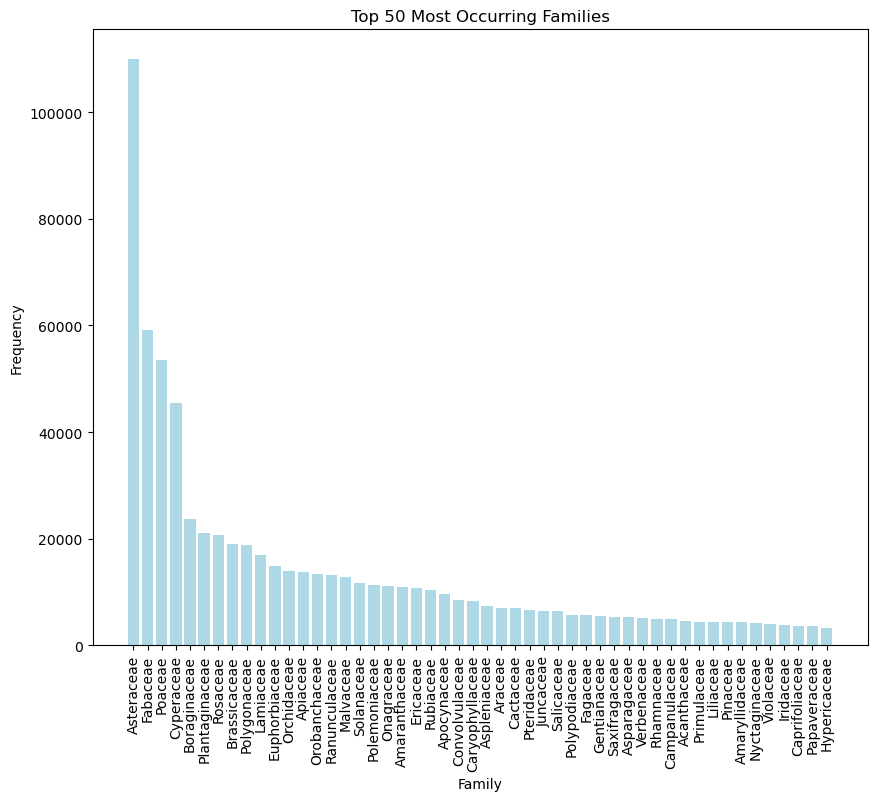

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

species_counter = Counter(species)
genus_counter = Counter(genus)
family_counter = Counter(family)

unique_species = len(species_counter)
unique_genus = len(genus_counter)
unique_family = len(family_counter)

family_top = family_counter.most_common(50)
genus_top = genus_counter.most_common(100)

items, count = zip(*family_top)

plt.figure(figsize=(10, 8))
plt.bar(items, count, color='lightblue')
plt.xlabel('Family')
plt.ylabel('Frequency')
plt.title('Top 50 Most Occurring Families')
plt.xticks(rotation=90)
plt.show()

## Train evaluation results

Correct captions: 9650

Correct family: 312266

Correct genus: 99588

Correct species: 10433

Total images: 839772

In [ ]:
import json

family_dict = {}
genus_dict = {}
species_dict = {}

with open("evaluation_result/family_dict.json", "r") as f:
    family_dict = json.load(f)

with open("evaluation_result/species_dict.json", "r") as f:
    # load the dictionary
    species_dict = json.load(f)

with open("evaluation_result/genus_dict.json", "r") as f:
    # load the dictionary
    genus_dict = json.load(f)

correct_species = {k: species_dict[k] / species_counter[k] for k in species_dict}
correct_genus = {k: genus_dict[k] / genus_counter[k] for k in genus_dict}
correct_family = {k: family_dict[k] / family_counter[k] for k in family_dict}

In [112]:
def get_family_from_genus(genus):
    try: 
        return categories_df[categories_df['genus'] == genus]['family'].values[0]
    except IndexError:
        return "Unknown"

def get_genus_from_species(species):
    return categories_df[categories_df['species'] == species]['genus'].values[0]

def get_family_from_species_genus(species, genus):
    return categories_df[(categories_df['species'] == species) & (categories_df['genus'] == genus)]['family'].values[0]

In [149]:
colors = {'Rosaceae': '#636efa',
 'Araceae': '#EF553B',
 'Cyperaceae': '#00cc96',
 'Pinaceae': '#ab63fa',
 'Fagaceae': '#FFA15A',
 'Pteridaceae': '#19d3f3',
 'Amaryllidaceae': '#FF6692',
 'Fabaceae': '#B6E880',
 'Acoraceae': '#FF97FF',
 'Brassicaceae': '#FECB52',
 'Apiaceae': '#636efa',
 'Plantaginaceae': '#EF553B',
 'Euphorbiaceae': '#00cc96',
 'Polygonaceae': '#ab63fa',
 'Zygophyllaceae': '#FFA15A',
 'Myricaceae': '#19d3f3',
 'Ericaceae': '#FF6692',
 'Asteraceae': '#B6E880',
 'Typhaceae': '#FF97FF',
 'Melanthiaceae': '#FECB52',
 'Onagraceae': '#636efa',
 'Iridaceae': '#EF553B',
 'Polypodiaceae': '#00cc96',
 'Amaranthaceae': '#ab63fa'}

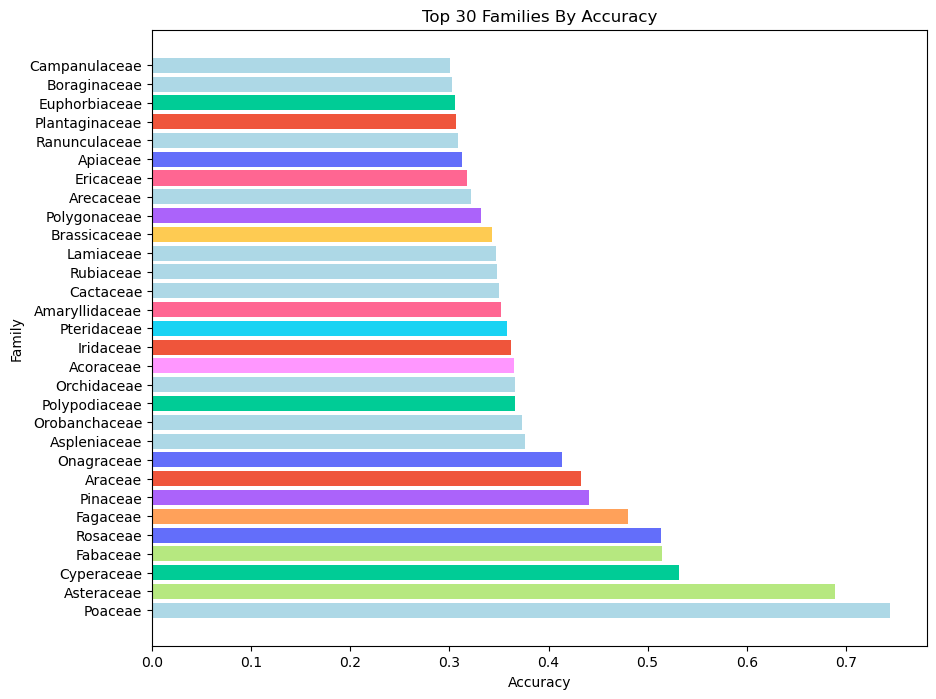

In [151]:
import plotly.express as px


def plot_top_n(counter, n, title, taxon, horizontal=False, color='lightblue'):
    try:
        items, count = zip(*counter.most_common(n))
    except AttributeError:
        sorted_dict = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n])

        items, count = zip(*sorted_dict.items())

    taxon = taxon.capitalize()

    if taxon != "Family":

        d = {
            "Genus": get_family_from_genus,
            "Species": get_genus_from_species
        }

        group = "Family" if taxon == "Genus" else "Genus"
    
        data = {
            taxon: items,
            'Count': count,
            group: [d[taxon](it) for it in items], 
            
        }

        hover_data = ["Family"] if taxon == "Species" else []

        if taxon == "Species":
            data['Family'] = [get_family_from_species_genus(it, d[taxon](it)) for it in items]
            hover_data = ["Family"]

        df = pd.DataFrame(data)
        fig = px.bar(df, x='Count', y=taxon, color=group, 
                    title=title, 
                    labels={'Count': 'Accuracy', taxon: taxon},
                    hover_data=hover_data,
                    )
        fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})

    else:

        color = [colors.get(it, 'lightblue') for it in items]
        fig = plt.figure(figsize=(10, 8))
        if horizontal:
            plt.barh(items, count, color=color)
            plt.xlabel('Accuracy')
            plt.ylabel('Family')
            plt.title(title)
            
        else:
            plt.bar(items, count, color=color)
            plt.xlabel('Family')
            plt.ylabel('Accuracy')
            plt.title(title)
            plt.xticks(rotation=90)
            
    fig.show()

    try: 
        color_mapping = {trace.name: trace.marker.color for trace in fig.data}
    except AttributeError:
        color_mapping = None

    return color_mapping
        
plot_top_n(correct_family, 30, "Top 30 Families By Accuracy", "family", horizontal=True)

In [145]:
mapping = plot_top_n(correct_genus, 30, "Top 30 Genus By Accuracy", "genus", horizontal=True, color='lightgreen')

In [136]:
plot_top_n(correct_species, 30, "Top 30 Species By Accuracy", "species", horizontal=True, color='lightcoral')